In [1]:
pip install pydot

Note: you may need to restart the kernel to use updated packages.


In [1]:
!pip install keras -tuner

  Using cached keras-2.14.0-py3-none-any.whl (1.7 MB)


In [2]:
!pip install keras_tuner

In [3]:
import pandas as pd
import numpy as np 
import tensorflow as tf
import seaborn as sns 
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings('ignore')

2023-10-10 20:54:20.860277: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
from sklearn.neural_network import MLPClassifier

import os
from os import listdir
from PIL import Image
import keras
from keras.models import Sequential
from tensorflow.keras import layers
#callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
from tensorflow.keras import utils
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split


import keras_tuner
from keras_tuner import RandomSearch
#from keras_tuner.engine.hyperparameters import HyperParameters

#transfer learning
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet_v2 import ResNet152V2
from keras.applications.xception import Xception

Using TensorFlow backend


In [6]:
input_shape_2D=(224,224)
input_shape_3D= (224,224,3)
seed=1
batch_size=32
epochs=30
stopper=EarlyStopping(patience=5)

In [8]:
#loading image data
data_ds= tf.keras.utils.image_dataset_from_directory(
    directory=r'/Users/saiterapalli/Desktop/Intern/Data',
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=None,
    image_size=input_shape_2D,
    seed=seed
)

Found 119 files belonging to 3 classes.


In [9]:
#class labels
class_names = data_ds.class_names

print("Class Names:", class_names)

Class Names: ['Bacterial_leaf_blight', 'Brown spot', 'Leaf smut']


In [10]:
def show_images(images, labels):
    fig, axes = plt.subplots(8, 4, figsize=(10, 10))
    axes = axes.flatten()
    for i, (img, label) in enumerate(zip(images, labels)):
        axes[i].imshow(img.numpy().astype("uint8"))
        axes[i].set_title(f"Label: {label}")
        axes[i].axis("off")
    plt.tight_layout()
    plt.show()

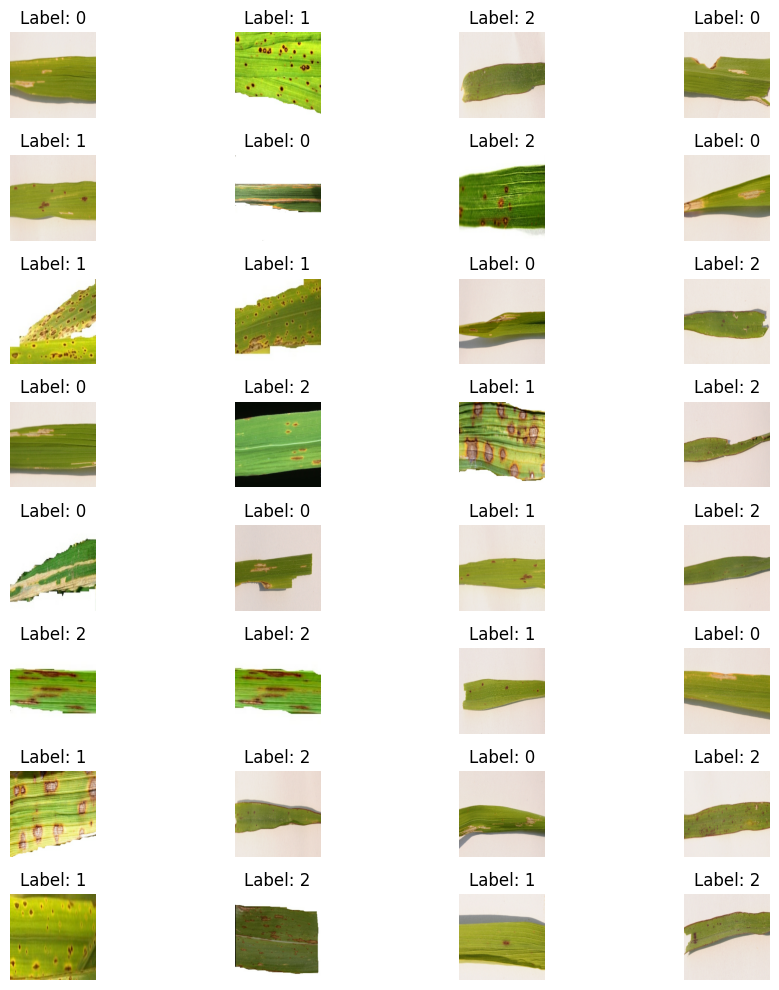

In [11]:
#displaying image batch of 32
batched_ds = data_ds.batch(batch_size)

batch = next(iter(batched_ds))
images, labels = batch

images, labels = next(iter(batched_ds))
show_images(images, labels)

In [12]:
X=[]
y= []

for image, label in data_ds.batch(119):
    for img, lab in zip(image, label): 
        X.append(img) 
        y.append(lab.numpy())

In [13]:
# converting to numpy array
X= np.array(X)
y= np.array(y)

In [14]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed)


In [15]:
X_train = X_train/255
X_test = X_test/255

In [16]:
print("shape of X_train_scaled:", X_train.shape)
print("shape of y_train:", y_train.shape)
print("shape of X_test_scaled:", X_test.shape)
print("shape of y_test:", y_test.shape)

shape of X_train_scaled: (89, 224, 224, 3)
shape of y_train: (89,)
shape of X_test_scaled: (30, 224, 224, 3)
shape of y_test: (30,)


# Encoding

In [17]:
y_train = to_categorical(y_train, num_classes=len(class_names))
y_test = to_categorical(y_test, num_classes=len(class_names))

In [18]:
own_model=Sequential()

# adding first convloutional layer
own_model.add(Conv2D(16, kernel_size=(3,3), padding='same', activation='relu', input_shape=input_shape_3D))
own_model.add(MaxPooling2D())

# adding second convloutional layer
own_model.add(Conv2D(32, kernel_size=(3,3), padding='same', activation='relu'))
own_model.add(MaxPooling2D())

# adding third convloutional layer
own_model.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'))
own_model.add(MaxPooling2D())

# adding flatten layer
own_model.add(Flatten())

# adding fully connected layers
own_model.add(Dense(200, activation='relu'))

#adding output layer : number of classes are 3
own_model.add(Dense(3, activation='softmax'))

In [19]:
# looking at the architecture summary
own_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 28, 28, 64)        0

In [20]:
# compiling model
own_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
#training model
checkpointer_own = ModelCheckpoint(filepath='own_model.weights.best.hdf5', verbose=3, save_best_only=True)

history=own_model.fit(X_train, y_train, validation_data= (X_test, y_test), epochs=epochs, callbacks=[checkpointer_own, stopper])

Epoch 1/30
3/3 [==============================] - ETA: 0s - loss: 2.7609 - accuracy: 0.3483
Epoch 1: val_loss improved from inf to 1.84410, saving model to own_model.weights.best.hdf5
3/3 [==============================] - 6s 2s/step - loss: 2.7609 - accuracy: 0.3483 - val_loss: 1.8441 - val_accuracy: 0.3000
Epoch 2/30
3/3 [==============================] - ETA: 0s - loss: 1.4169 - accuracy: 0.3371
Epoch 2: val_loss improved from 1.84410 to 1.08607, saving model to own_model.weights.best.hdf5
3/3 [==============================] - 5s 1s/step - loss: 1.4169 - accuracy: 0.3371 - val_loss: 1.0861 - val_accuracy: 0.3000
Epoch 3/30
3/3 [==============================] - ETA: 0s - loss: 1.0823 - accuracy: 0.4494
Epoch 3: val_loss improved from 1.08607 to 1.07921, saving model to own_model.weights.best.hdf5
3/3 [==============================] - 3s 1s/step - loss: 1.0823 - accuracy: 0.4494 - val_loss: 1.0792 - val_accuracy: 0.2667
Epoch 4/30
3/3 [==============================] - ETA: 0s - lo

In [22]:
def plot_performance(model_name, acc, val_acc, loss, val_loss):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.plot(loss)
    plt.plot(val_loss)
    plt.title('{} : Loss'.format(model_name), fontsize=12, fontweight='bold')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper right')

    plt.subplot(1,2,2)
    plt.plot(acc)
    plt.plot(val_acc)
    plt.title('{} : Accuracy'.format(model_name), fontsize=12, fontweight='bold')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper right')

    plt.tight_layout()

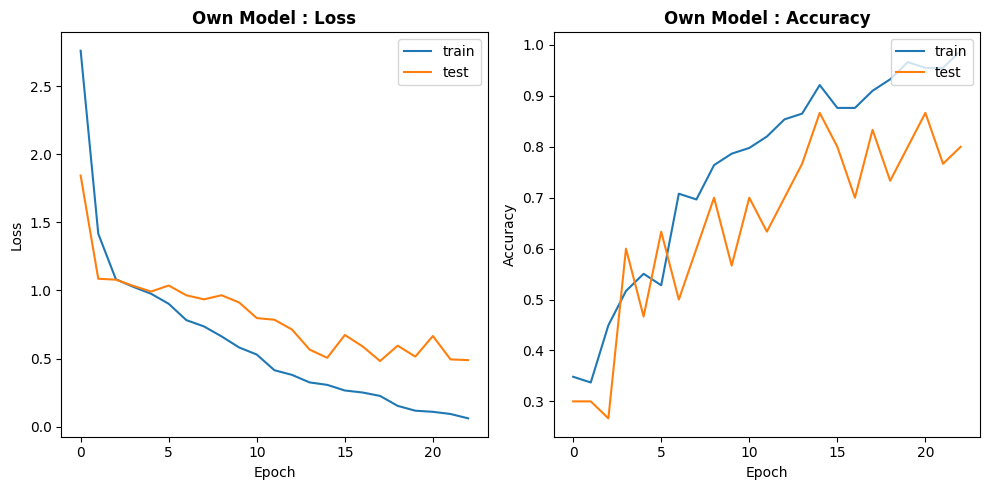

In [23]:
plot_performance(model_name= 'Own Model',
                 acc=history.history['accuracy'], 
                 val_acc=history.history['val_accuracy'],
                 loss=history.history['loss'], 
                 val_loss=history.history['val_loss'])

In [24]:
#creating image generator object
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    horizontal_flip=True,
    vertical_flip=True)

In [25]:
#training model
checkpointer_own_aug = ModelCheckpoint(filepath='own_model_aug.weights.best.hdf5', verbose=3, save_best_only=True)

aug_history= own_model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_test, y_test),
    steps_per_epoch=len(X_train)//batch_size, 
    epochs=epochs,
    callbacks=[stopper, checkpointer_own_aug]
)

Epoch 1/30
2/2 [==============================] - ETA: 0s - loss: 2.5761 - accuracy: 0.5439
Epoch 1: val_loss improved from inf to 0.87367, saving model to own_model_aug.weights.best.hdf5
2/2 [==============================] - 4s 2s/step - loss: 2.5761 - accuracy: 0.5439 - val_loss: 0.8737 - val_accuracy: 0.8000
Epoch 2/30
2/2 [==============================] - ETA: 0s - loss: 1.7698 - accuracy: 0.5439
Epoch 2: val_loss improved from 0.87367 to 0.65164, saving model to own_model_aug.weights.best.hdf5
2/2 [==============================] - 3s 2s/step - loss: 1.7698 - accuracy: 0.5439 - val_loss: 0.6516 - val_accuracy: 0.7667
Epoch 3/30
2/2 [==============================] - ETA: 0s - loss: 0.8538 - accuracy: 0.5938
Epoch 3: val_loss did not improve from 0.65164
2/2 [==============================] - 3s 1s/step - loss: 0.8538 - accuracy: 0.5938 - val_loss: 0.6628 - val_accuracy: 0.7333
Epoch 4/30
2/2 [==============================] - ETA: 0s - loss: 0.9292 - accuracy: 0.4386
Epoch 4: va

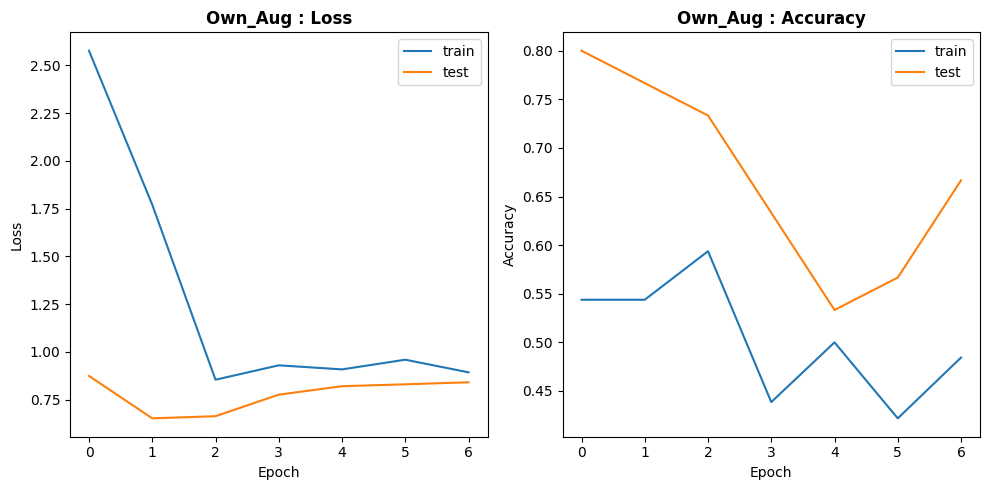

In [26]:
#visualising model performance
plot_performance(model_name='Own_Aug',
                  acc=aug_history.history['accuracy'], 
                 val_acc=aug_history.history['val_accuracy'],
                 loss=aug_history.history['loss'], 
                 val_loss=aug_history.history['val_loss'])

In [27]:
def build_model(hp):
    new_model=Sequential()
    # adding first convloutional layer
    new_model.add(Conv2D(
        filters= hp.Int('conv_1_filter', min_value=8, max_value=32, step=8),
        kernel_size=hp.Choice('conv_1_kernel', values= [2,3]),
        padding=hp.Choice('conv_1_pad', values=['same', 'valid']),
        activation='relu', input_shape=input_shape_3D))
    new_model.add(MaxPooling2D())
    
    # adding second convloutional layer
    new_model.add(Conv2D(
        filters= hp.Int('conv_2_filter', min_value=16, max_value=64, step=16),
        kernel_size=hp.Choice('conv_2_kernel', values= [2,3]),
        padding=hp.Choice('conv_2_pad', values=['same', 'valid']),
        activation='relu'))
    new_model.add(MaxPooling2D())
    
    # adding second convloutional layer
    new_model.add(Conv2D(
        filters= hp.Int('conv_3_filter', min_value=32, max_value=64, step=16),
        kernel_size=hp.Choice('conv_3_kernel', values= [2,3]),
        padding=hp.Choice('conv_3_pad', values=['same', 'valid']),
        activation='relu'))
    new_model.add(MaxPooling2D())
    
     # adding flatten layer
    new_model.add(Dense(
        units=hp.Int('dense_1_units', min_value=50, max_value=250, step=50),activation='relu'))
    #adding output layer : number of classes are 3
    new_model.add(Dense(3, activation='softmax'))
    new_model.compile(
      optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3])),loss='categorical_crossentropy',
      metrics=['accuracy'])
    return new_model



In [28]:
tuner_search=RandomSearch(build_model, objective='val_accuracy', 
                          max_trials=3, 
                          directory='output', 
                          project_name='RiceLeafDisease')

In [29]:
def build_model(hp):
    # Create a Sequential model
    model = Sequential()

    # Data augmentation
    model.add(
        layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(224, 224, 3))
    )
    model.add(
        layers.experimental.preprocessing.RandomRotation(0.1)
    )
    model.add(
        layers.experimental.preprocessing.RandomZoom(0.1)
    )

    # Add the first convolutional layer
    model.add(Conv2D(
        filters=hp.Int('conv_1_filter', min_value=8, max_value=32, step=8),
        kernel_size=hp.Choice('conv_1_kernel', values=[2, 3]),
        padding=hp.Choice('conv_1_pad', values=['same', 'valid']),
        activation='relu')
    )
    model.add(MaxPooling2D())

    # Add more layers ... (follow your model architecture)

    # Flatten layer
    model.add(Flatten())

    # Add the output layer
    model.add(Dense(3, activation='softmax'))

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3])),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Create a tuner
tuner_search = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=3,
    directory='output',
    project_name='Data'
)

# Search using the training and validation data
tuner_search.search(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10
)


Trial 3 Complete [00h 00m 22s]
val_accuracy: 0.4333333373069763

Best val_accuracy So Far: 0.5
Total elapsed time: 00h 01m 11s




* Here's a breakdown of the modified approach step by step:

1. **`layers.experimental.preprocessing` for Data Augmentation**:
   We use various preprocessing layers from `layers.experimental.preprocessing` to apply data augmentation directly within the model. These layers include:
   - `RandomFlip("horizontal", input_shape=(224, 224, 3))`: Randomly flips images horizontally.
   - `RandomRotation(0.1)`: Applies a random rotation to the images.
   - `RandomZoom(0.1)`: Randomly zooms into the images.

2. **Model Architecture and Hyperparameters**:
   We define the model architecture in the `build_model` function, similar to your previous approach. However, we've integrated the data augmentation layers before the first convolutional layer.

3. **Hyperparameter Tuning**:
   We define a tuner using `RandomSearch` to search for the best hyperparameters that maximize the validation accuracy. The hyperparameters include filter sizes, kernel sizes, padding, and learning rates.

4. **Training with Tuner**:
   We use the tuner to search for the best hyperparameters using the training and validation data, and we specify the validation data. The tuner will perform the search and try different hyperparameter combinations to maximize validation accuracy.

By integrating data augmentation within the model and using a tuner to optimize hyperparameters, we aim to resolve any shape compatibility issues related to data augmentation and the training process.


In [30]:
tuned_model=tuner_search.get_best_models(num_models=1)[0]

In [31]:
tuned_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 224, 224, 3)       0         
                                                                 
 random_rotation (RandomRot  (None, 224, 224, 3)       0         
 ation)                                                          
                                                                 
 random_zoom (RandomZoom)    (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 8)       224       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 8)       0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 98568)             0

In [32]:
#training model
checkpointer_own_tuned = ModelCheckpoint(filepath='own_model_tuned.weights.best.hdf5', verbose=3, save_best_only=True)

tuned_history= tuned_model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_test, y_test),
    steps_per_epoch=len(X_train)//batch_size, 
    initial_epoch=10,
    epochs=epochs,
    callbacks=[stopper, checkpointer_own_tuned]
)

Epoch 11/30
2/2 [==============================] - ETA: 0s - loss: 12.0645 - accuracy: 0.4062
Epoch 11: val_loss improved from inf to 1.76720, saving model to own_model_tuned.weights.best.hdf5
2/2 [==============================] - 4s 2s/step - loss: 12.0645 - accuracy: 0.4062 - val_loss: 1.7672 - val_accuracy: 0.3333
Epoch 12/30
2/2 [==============================] - ETA: 0s - loss: 2.1904 - accuracy: 0.5263
Epoch 12: val_loss improved from 1.76720 to 0.87863, saving model to own_model_tuned.weights.best.hdf5
2/2 [==============================] - 4s 3s/step - loss: 2.1904 - accuracy: 0.5263 - val_loss: 0.8786 - val_accuracy: 0.7000
Epoch 13/30
2/2 [==============================] - ETA: 0s - loss: 1.0651 - accuracy: 0.4912
Epoch 13: val_loss did not improve from 0.87863
2/2 [==============================] - 2s 780ms/step - loss: 1.0651 - accuracy: 0.4912 - val_loss: 1.0711 - val_accuracy: 0.5000
Epoch 14/30
2/2 [==============================] - ETA: 0s - loss: 1.0671 - accuracy: 0.

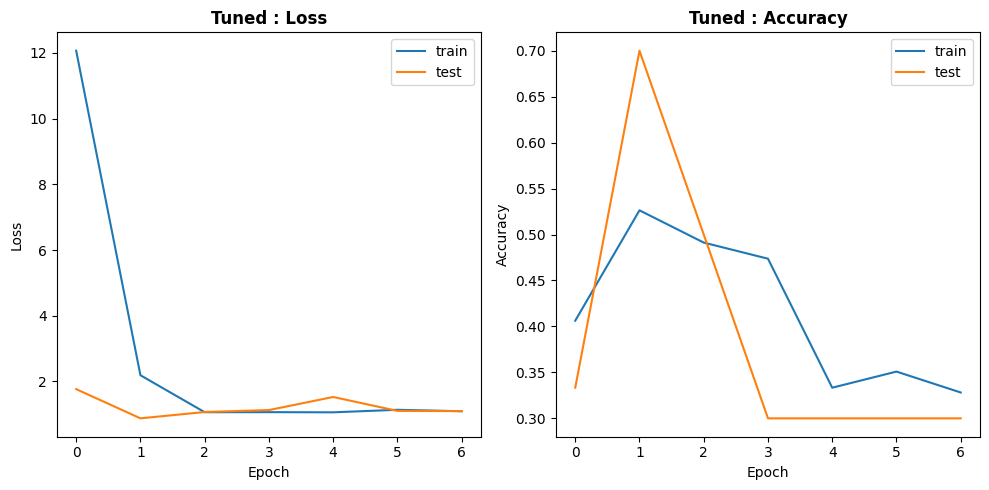

In [33]:
plot_performance(model_name='Tuned',
                  acc=tuned_history.history['accuracy'], 
                 val_acc=tuned_history.history['val_accuracy'],
                 loss=tuned_history.history['loss'], 
                 val_loss=tuned_history.history['val_loss'])

# Transfer Learning

# InceptionV3

In [34]:
inception_base=tf.keras.applications.InceptionV3(
    include_top=False,
    weights="imagenet",
    input_shape=input_shape_3D,
)

#unfreezing the convloution layers
inception_base.trainable=True
set_trainable=False

for layer in inception_base.layers:
    if layer.name=='mixed9_0':
        set_trainable=True
    if set_trainable==True:
        layer.trainable=True
else:
    layer.trainable=False


# building fully connected layers
inception_model= Sequential()

inception_model.add(inception_base)
inception_model.add(Flatten())

inception_model.add(Dense(128, activation='relu'))
inception_model.add(Dense(3, activation='softmax'))


#compiling 
inception_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [38]:
!pip install pydot

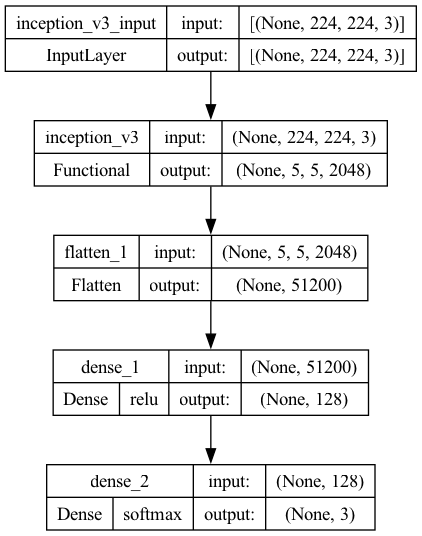

In [39]:
tf.keras.utils.plot_model(
    inception_model,
    show_shapes=True,
    show_layer_names=True,
    show_layer_activations=True
)

In [40]:
#training model
checkpointer_inception = ModelCheckpoint(filepath='inception.weights.best.hdf5', verbose=3, save_best_only=True)

inception_history= inception_model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=epochs,
    callbacks=[stopper, checkpointer_inception]
)

Epoch 1/30
3/3 [==============================] - ETA: 0s - loss: 7.1134 - accuracy: 0.4045 
Epoch 1: val_loss improved from inf to 24.03800, saving model to inception.weights.best.hdf5
3/3 [==============================] - 78s 18s/step - loss: 7.1134 - accuracy: 0.4045 - val_loss: 24.0380 - val_accuracy: 0.4333
Epoch 2/30
3/3 [==============================] - ETA: 0s - loss: 9.0029 - accuracy: 0.5169  
Epoch 2: val_loss did not improve from 24.03800
3/3 [==============================] - 48s 16s/step - loss: 9.0029 - accuracy: 0.5169 - val_loss: 246.4957 - val_accuracy: 0.3000
Epoch 3/30
3/3 [==============================] - ETA: 0s - loss: 1.1645 - accuracy: 0.8090 
Epoch 3: val_loss did not improve from 24.03800
3/3 [==============================] - 33s 11s/step - loss: 1.1645 - accuracy: 0.8090 - val_loss: 930.6561 - val_accuracy: 0.3667
Epoch 4/30
3/3 [==============================] - ETA: 0s - loss: 0.5690 - accuracy: 0.7528 
Epoch 4: val_loss did not improve from 24.03800
3

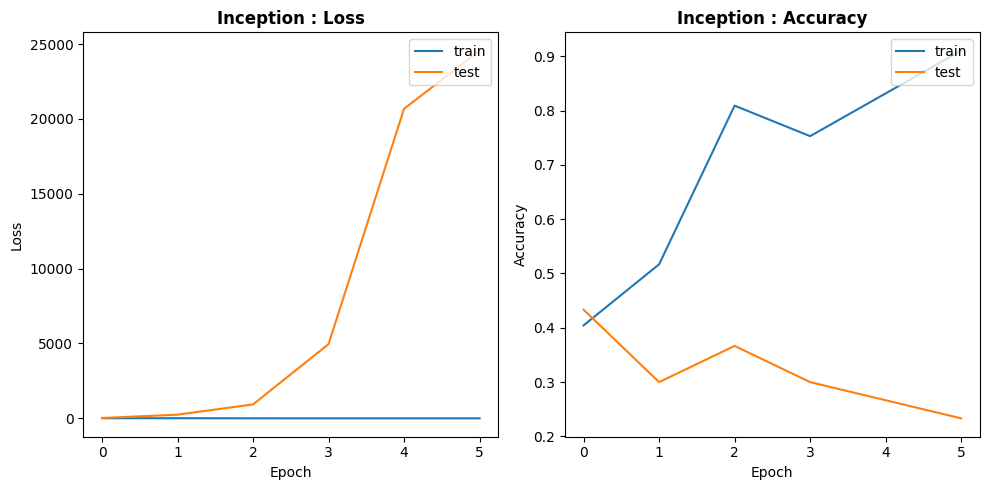

In [41]:
plot_performance(model_name='Inception',
                acc=inception_history.history['accuracy'], 
                 val_acc=inception_history.history['val_accuracy'],
                 loss=inception_history.history['loss'], 
                 val_loss=inception_history.history['val_loss'])


In [42]:
#training model
checkpointer_inception_aug = ModelCheckpoint(filepath='inception_aug.weights.best.hdf5', verbose=3, save_best_only=True)

inception_history_aug= inception_model.fit(
    datagen.flow(X_train,y_train, batch_size=batch_size),
    validation_data=(X_test, y_test),
    steps_per_epoch=len(X_train)//batch_size,
    epochs=epochs,
    callbacks=[stopper, checkpointer_inception_aug]
)

Epoch 1/30
2/2 [==============================] - ETA: 0s - loss: 1.2500 - accuracy: 0.6875 
Epoch 1: val_loss improved from inf to 48740.78516, saving model to inception_aug.weights.best.hdf5
2/2 [==============================] - 41s 17s/step - loss: 1.2500 - accuracy: 0.6875 - val_loss: 48740.7852 - val_accuracy: 0.2667
Epoch 2/30
2/2 [==============================] - ETA: 0s - loss: 1.8823 - accuracy: 0.7368 
Epoch 2: val_loss did not improve from 48740.78516
2/2 [==============================] - 23s 11s/step - loss: 1.8823 - accuracy: 0.7368 - val_loss: 63447.1641 - val_accuracy: 0.2667
Epoch 3/30
2/2 [==============================] - ETA: 0s - loss: 0.6177 - accuracy: 0.7500 
Epoch 3: val_loss did not improve from 48740.78516
2/2 [==============================] - 30s 14s/step - loss: 0.6177 - accuracy: 0.7500 - val_loss: 134935.0312 - val_accuracy: 0.4333
Epoch 4/30
2/2 [==============================] - ETA: 0s - loss: 2.7942 - accuracy: 0.5938 
Epoch 4: val_loss did not imp

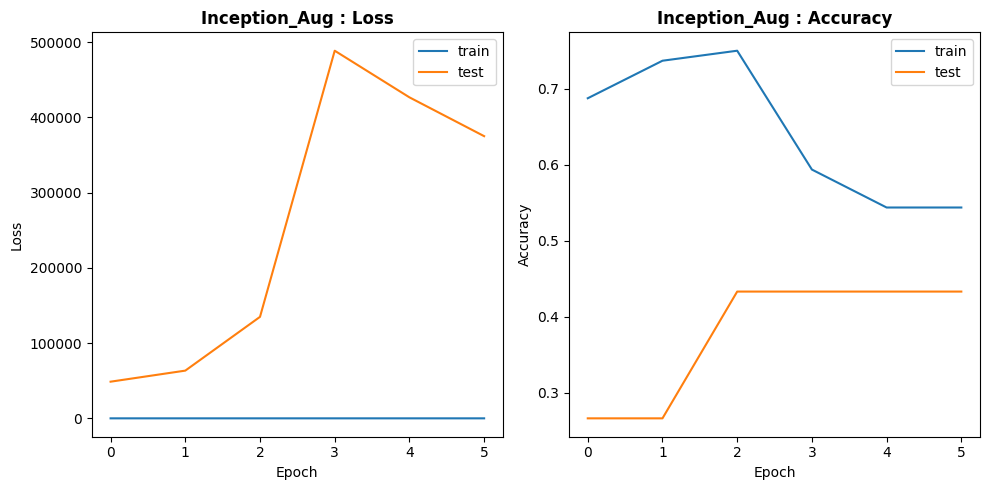

In [43]:
plot_performance(model_name='Inception_Aug',
                acc=inception_history_aug.history['accuracy'], 
                 val_acc=inception_history_aug.history['val_accuracy'],
                 loss=inception_history_aug.history['loss'], 
                 val_loss=inception_history_aug.history['val_loss'])

# Xception
* Xception is a deep neural network architecture proposed by Google researchers in 2016. It is an extension of the Inception architecture that replaces the standard Inception modules with depthwise separable convolutions, which are computationally efficient and lead to improved performance. Xception has achieved state-of-the-art results on various computer vision tasks and is commonly used in transfer learning applications.

In [44]:
xception_base= Xception(
    include_top=False,
    weights='imagenet',
    input_shape=input_shape_3D
)

xception_base.trainable=True
set_trainable=False

for layer in xception_base.layers:
    if layer.name=='add_8':
        set_trainable=True
    if set_trainable==True:
        layer.trainable=True
else:
    layer.trainable=False

#building fully connected layers
xception_model=Sequential()

xception_model.add(xception_base)
xception_model.add(Flatten())

xception_model.add(Dense(128, activation='relu'))
xception_model.add(Dense(3, activation='softmax'))

xception_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

83683744/83683744 [==============================] - 6s 0us/step


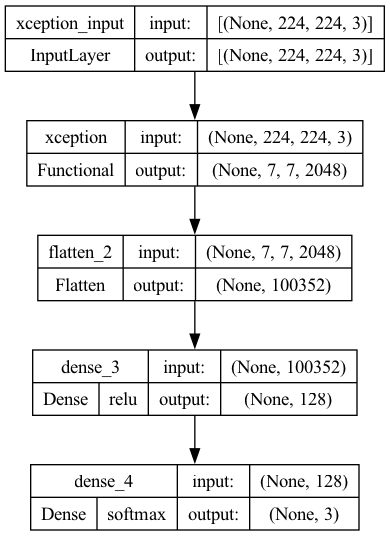

In [45]:
tf.keras.utils.plot_model(
    xception_model,
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=True
)

In [46]:
#training model
checkpointer_xception = ModelCheckpoint(filepath='xception.weights.best.hdf5', verbose=3, save_best_only=True)

xception_history=xception_model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=epochs,
    callbacks=[stopper, checkpointer_xception]
)

Epoch 1/30
3/3 [==============================] - ETA: 0s - loss: 7.6342 - accuracy: 0.3483 
Epoch 1: val_loss improved from inf to 6.17463, saving model to xception.weights.best.hdf5
3/3 [==============================] - 79s 23s/step - loss: 7.6342 - accuracy: 0.3483 - val_loss: 6.1746 - val_accuracy: 0.3000
Epoch 2/30
3/3 [==============================] - ETA: 0s - loss: 1.0983 - accuracy: 0.3708 
Epoch 2: val_loss improved from 6.17463 to 1.08516, saving model to xception.weights.best.hdf5
3/3 [==============================] - 65s 21s/step - loss: 1.0983 - accuracy: 0.3708 - val_loss: 1.0852 - val_accuracy: 0.5333
Epoch 3/30
3/3 [==============================] - ETA: 0s - loss: 1.0986 - accuracy: 0.3371 
Epoch 3: val_loss did not improve from 1.08516
3/3 [==============================] - 68s 22s/step - loss: 1.0986 - accuracy: 0.3371 - val_loss: 1.0998 - val_accuracy: 0.3333
Epoch 4/30
3/3 [==============================] - ETA: 0s - loss: 1.0986 - accuracy: 0.3371 
Epoch 4: va

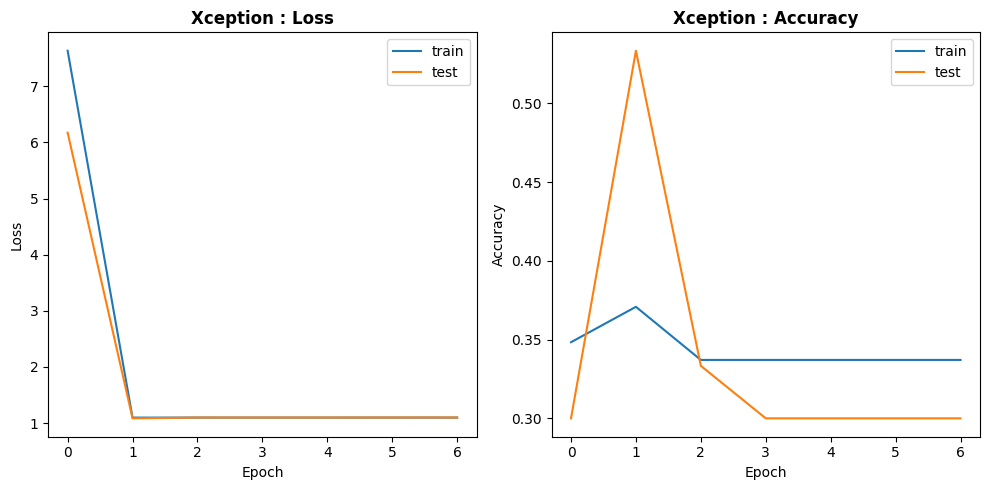

In [47]:
plot_performance(model_name='Xception',
                acc=xception_history.history['accuracy'], 
                 val_acc=xception_history.history['val_accuracy'],
                 loss=xception_history.history['loss'], 
                 val_loss=xception_history.history['val_loss'])

In [48]:
checkpointer_xception_aug = ModelCheckpoint(filepath='xception_aug.weights.best.hdf5', verbose=3, save_best_only=True)

xception_history_aug=xception_model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_test, y_test),
    steps_per_epoch=len(X_train)//batch_size,
    epochs=epochs,
    callbacks=[stopper, checkpointer_xception_aug]
)

Epoch 1/30
2/2 [==============================] - ETA: 0s - loss: 1.0985 - accuracy: 0.3333 
Epoch 1: val_loss improved from inf to 1.10076, saving model to xception_aug.weights.best.hdf5
2/2 [==============================] - 44s 17s/step - loss: 1.0985 - accuracy: 0.3333 - val_loss: 1.1008 - val_accuracy: 0.3000
Epoch 2/30
2/2 [==============================] - ETA: 0s - loss: 1.0975 - accuracy: 0.4211 
Epoch 2: val_loss did not improve from 1.10076
2/2 [==============================] - 46s 32s/step - loss: 1.0975 - accuracy: 0.4211 - val_loss: 1.1009 - val_accuracy: 0.3000
Epoch 3/30
2/2 [==============================] - ETA: 0s - loss: 1.0991 - accuracy: 0.2969 
Epoch 3: val_loss did not improve from 1.10076
2/2 [==============================] - 51s 26s/step - loss: 1.0991 - accuracy: 0.2969 - val_loss: 1.1011 - val_accuracy: 0.3000
Epoch 4/30
2/2 [==============================] - ETA: 0s - loss: 1.0990 - accuracy: 0.3684 
Epoch 4: val_loss did not improve from 1.10076
2/2 [===

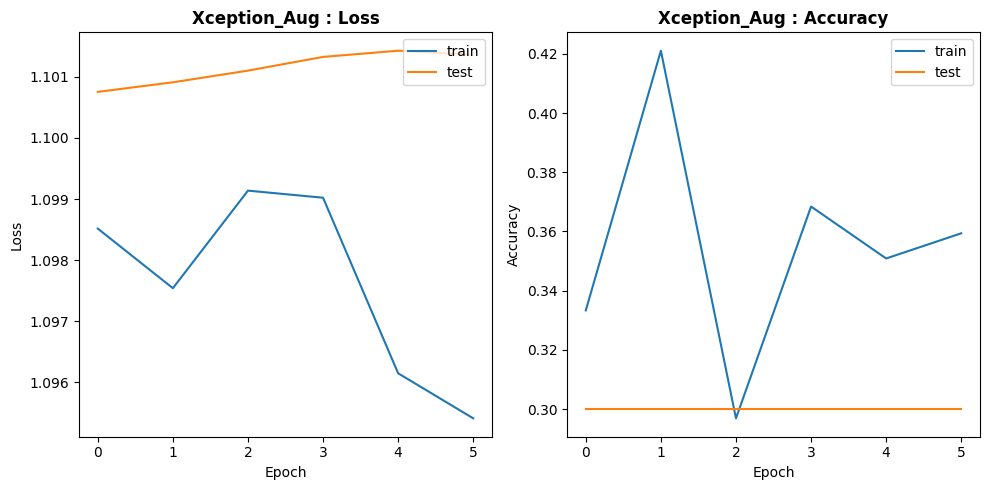

In [49]:
plot_performance(model_name='Xception_Aug',
                acc=xception_history_aug.history['accuracy'], 
                 val_acc=xception_history_aug.history['val_accuracy'],
                 loss=xception_history_aug.history['loss'], 
                 val_loss=xception_history_aug.history['val_loss'])

## Loading Best Model

In [50]:
xception_model.load_weights('xception_aug.weights.best.hdf5')

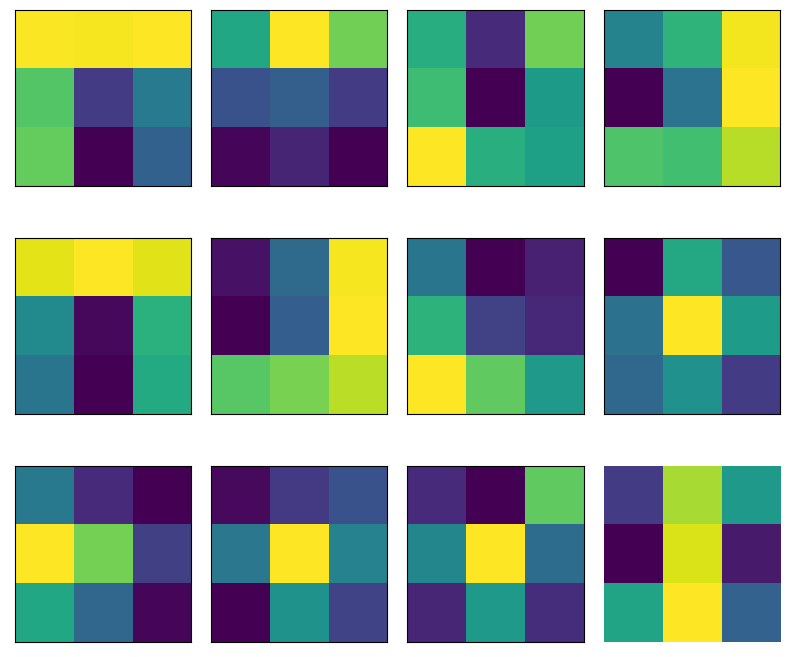

In [51]:
fig, ax= plt.subplots(3,4, figsize=(8,8))

for i, ax in zip(range(12), ax.flatten()):
    conv1=xception_model.layers[0]
    weights1 = conv1.get_weights()
    kernels1 = weights1[0]
    kernel1_1 = kernels1[:,:,0,i]
    ax.imshow(kernel1_1)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.tight_layout()
    plt.axis('off');

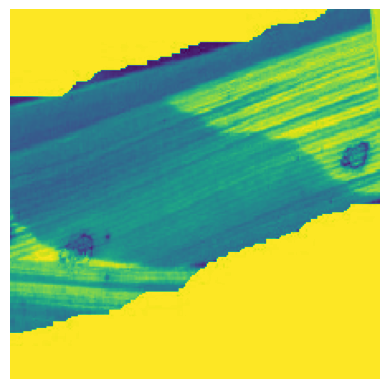

In [52]:
image = tf.keras.utils.load_img('./Brown spot//DSC_0112.jpg', target_size=input_shape_2D)
input_arr = tf.keras.utils.img_to_array(image)/255
image = input_arr[:, :, 1]
plt.imshow(image)
plt.axis('off');

In [53]:
import numpy as np

def convolution(image, kernel):
    # Get the size of the kernel
    kernel_size = kernel.shape[0]

    # Calculate the size of the output image
    output_size = image.shape[0] - kernel_size + 1

    # Initialize the output image
    output_image = np.zeros((output_size, output_size))

    # Pad the image with zeros
    padded_image = np.pad(image, ((kernel_size-1)//2, (kernel_size-1)//2), 'constant')

    # Apply the convolution operation
    for ii in range(output_size):
        for jj in range(output_size):
            window = padded_image[ii:ii+kernel_size, jj:jj+kernel_size]
            output_image[ii, jj] = np.sum(window * kernel)

    return output_image

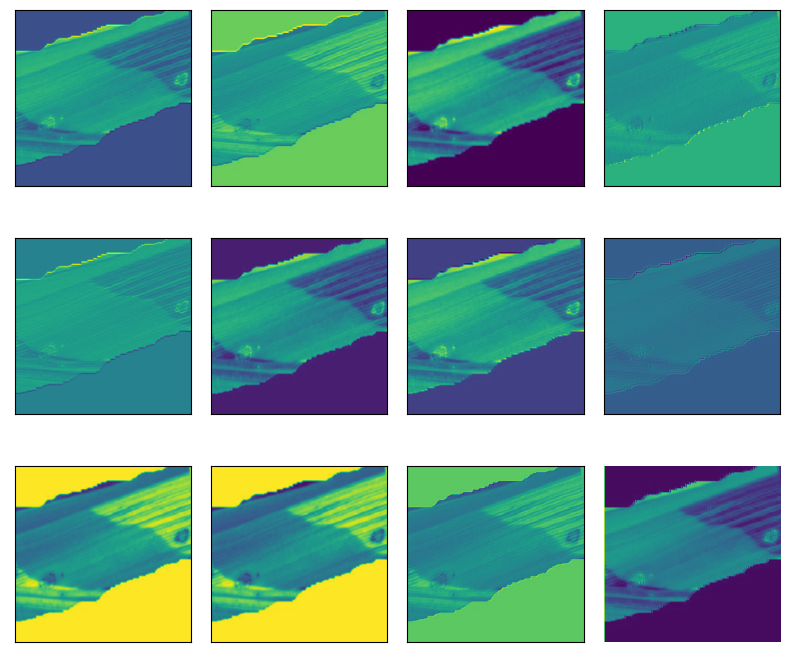

In [54]:
fig, ax= plt.subplots(3,4, figsize=(8,8))

for i, ax in zip(range(12), ax.flatten()):
    conv1=xception_model.layers[0]
    weights1 = conv1.get_weights()
    kernels1 = weights1[0]
    kernel1_1 = kernels1[:,:,0,i]

    output=convolution(image, kernel1_1)

    ax.imshow(output)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.tight_layout()
    plt.axis('off');

### Visualising Prediction

In [55]:
# get predictions on the test set
y_hat = xception_model.predict(X_test)

# define text labels
labels = data_ds.class_names

1/1 [==============================] - 4s 4s/step


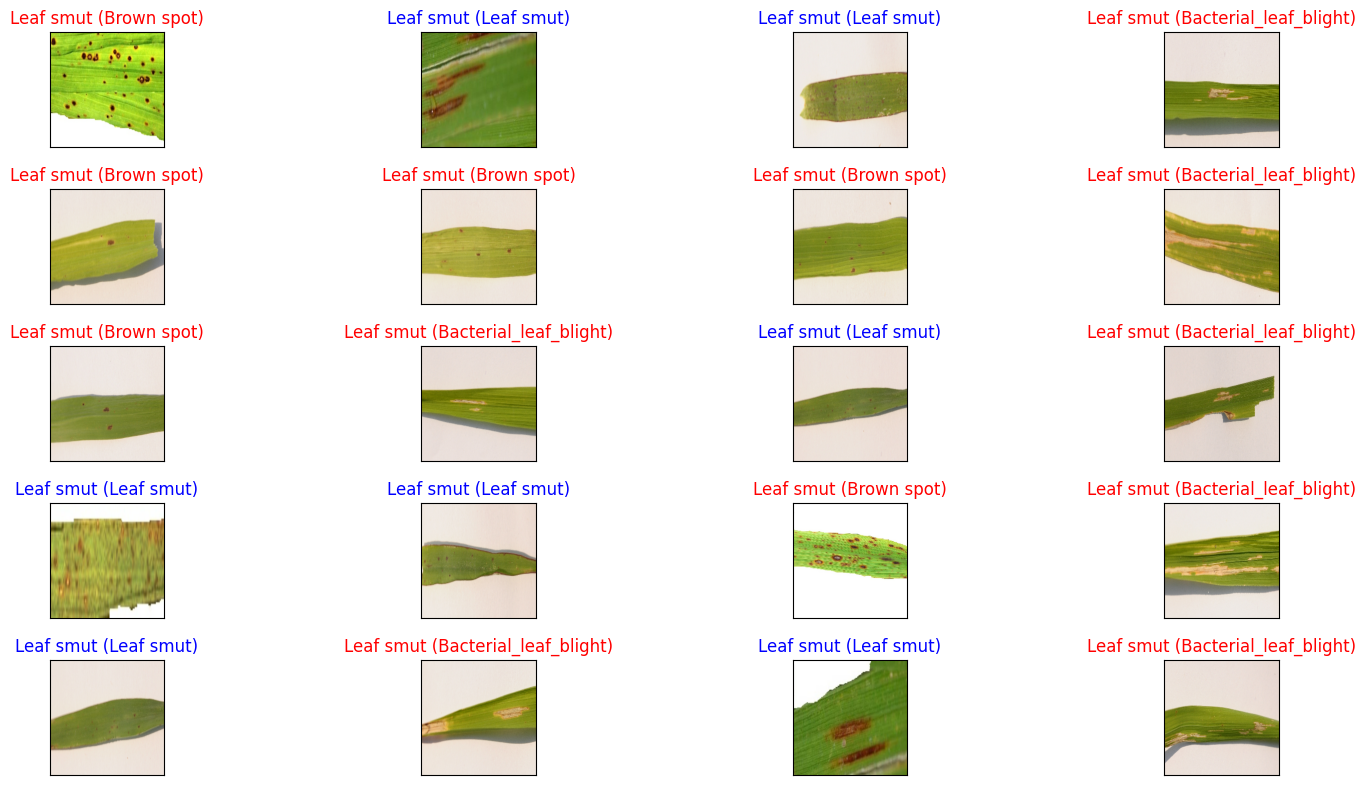

In [56]:
# plot a random sample of test images, their predicted labels, and ground truth
fig = plt.figure(figsize=(20, 8))
for i, idx in enumerate(np.random.choice(X_test.shape[0], size=20, replace=False)):
    ax = fig.add_subplot(5, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_test[idx]))
    pred_idx = np.argmax(y_hat[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(labels[pred_idx], labels[true_idx]),
                 color=("blue" if pred_idx == true_idx else "red"))
    plt.tight_layout()